## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [63]:
!nvidia-smi

Thu May 22 19:34:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P0             28W /   70W |    8126MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

### Install SAM2 and dependencies

In [64]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/content/segment-anything-2
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [ ]:
!pip install git+https://github.com/facebookresearch/sam2.git

In [65]:
!pip install -q supervision jupyter_bbox_widget

### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [66]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

^C
^C


### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [67]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [79]:
%cd {HOME}

/content


In [1]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!cd GroundingDINO

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 17.76 MiB/s, done.
Resolving deltas: 100% (241/241), done.


### Imports

In [68]:
import os
import torch
import numpy as np
from PIL import Image
import supervision as sv

from transformers import AutoModelForCausalLM, AutoProcessor
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [69]:
# --- Florence utilities (from utils/florence.py) ---
FLORENCE_CHECKPOINT = "microsoft/Florence-2-base"
FLORENCE_OPEN_VOCABULARY_DETECTION_TASK = "<OPEN_VOCABULARY_DETECTION>"

def load_florence_model(device: torch.device):
    """Load Florence-2 model & processor."""
    model = AutoModelForCausalLM.from_pretrained(
        FLORENCE_CHECKPOINT, trust_remote_code=True
    ).to(device).eval()
    processor = AutoProcessor.from_pretrained(
        FLORENCE_CHECKPOINT, trust_remote_code=True
    )
    return model, processor

def run_florence_inference(model, processor, device, image: Image.Image, text: str):
    """Run Florence on image + text prompt."""
    prompt = FLORENCE_OPEN_VOCABULARY_DETECTION_TASK + text
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    gen = processor.batch_decode(outputs, skip_special_tokens=False)[0]
    # post_process_generation returns a dict with 'boxes' and 'labels'
    resp = processor.post_process_generation(gen,
                task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
                image_size=image.size)
    return resp  # e.g. {"boxes": [...], "labels": [...]}
# :contentReference[oaicite:0]{index=0}

# --- SAM 2 utilities (adapted from utils/sam.py) ---
SAM_CONFIG = "./configs/sam2/sam2_hiera_l.yaml"
SAM_CHECKPOINT = "./checkpoints/sam2_hiera_large.pt"

def load_sam_image_model(device: torch.device):
    """Build and wrap the hiera_large SAM2 model."""
    sam_model = build_sam2(SAM_CONFIG, SAM_CHECKPOINT, device=device)
    return SAM2ImagePredictor(sam_model)

def run_sam_inference(predictor: SAM2ImagePredictor,
                      image: Image.Image,
                      boxes: np.ndarray):
    """Run SAM2 on detected boxes to produce masks."""
    rgb = np.array(image.convert("RGB"))
    predictor.set_image(rgb)
    # single-mask per box
    masks, scores, _ = predictor.predict(box=boxes, multimask_output=False)
    # masks: (N, H, W)
    return masks
# :contentReference[oaicite:1]{index=1}

In [83]:

IMAGE_PATH = f"{HOME}/data/1.jpeg"
prompt = "find the ruler"
out_path = f"{HOME}/data/1_ruler.jpeg"

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load models
flor_model, flor_proc = load_florence_model(device)
sam_predictor   = load_sam_image_model(device)

In [84]:
# load image
image_path = IMAGE_PATH
image = Image.open(image_path).convert("RGB")
text_prompt = prompt
# run Florence for each comma-separated text
texts = [t.strip() for t in text_prompt.split(",") if t.strip()]
all_boxes, all_labels = [], []

In [85]:
for txt in texts:
    resp = run_florence_inference(flor_model, flor_proc, device, image, txt)
    # resp["boxes"]: List of [x1,y1,x2,y2], resp["labels"]: list of ints
    all_boxes.extend(resp['<OPEN_VOCABULARY_DETECTION>']['bboxes'])
    all_labels.extend(resp['<OPEN_VOCABULARY_DETECTION>']['bboxes_labels'])

if not all_boxes:
    print(f"No regions found for prompt: '{text_prompt}'")

boxes = np.array(all_boxes)
labels= all_labels

In [86]:
# run SAM on all detected boxes
masks = run_sam_inference(sam_predictor, image, boxes)



In [87]:
def annotate(image: Image.Image, boxes: np.ndarray, masks: np.ndarray, labels: list[str]):
    """
    Overlay masks, boxes, and text labels on the image.
    - boxes: (N,4) array of [x1,y1,x2,y2]
    - masks: (N,H,W) boolean array of masks
    - labels: list of N human-readable strings
    """
    scene = np.array(image.convert("RGB"))
    masks = masks.astype(bool)
    # Create a Detections object
    det = sv.Detections(
        xyxy     = boxes,
        mask     = masks,
        class_id = np.arange(len(labels))  # dummy IDs
    )

    # Use INDEX color-mapping so each detection gets its own color
    mask_annotator  = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    box_annotator   = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

    # Draw masks, boxes, and finally the text labels
    scene = mask_annotator.annotate(scene=scene, detections=det)
    scene = box_annotator.annotate(scene=scene, detections=det)
    scene = label_annotator.annotate(
        scene      = scene,
        detections = det,
        labels     = labels
    )

    return Image.fromarray(scene)


In [88]:
# annotate and save
annotated = annotate(image, boxes, masks, labels)
output_path = out_path
annotated.save(output_path)
print(f"Result saved to {output_path}")

Result saved to /content/data/1_ruler.jpeg


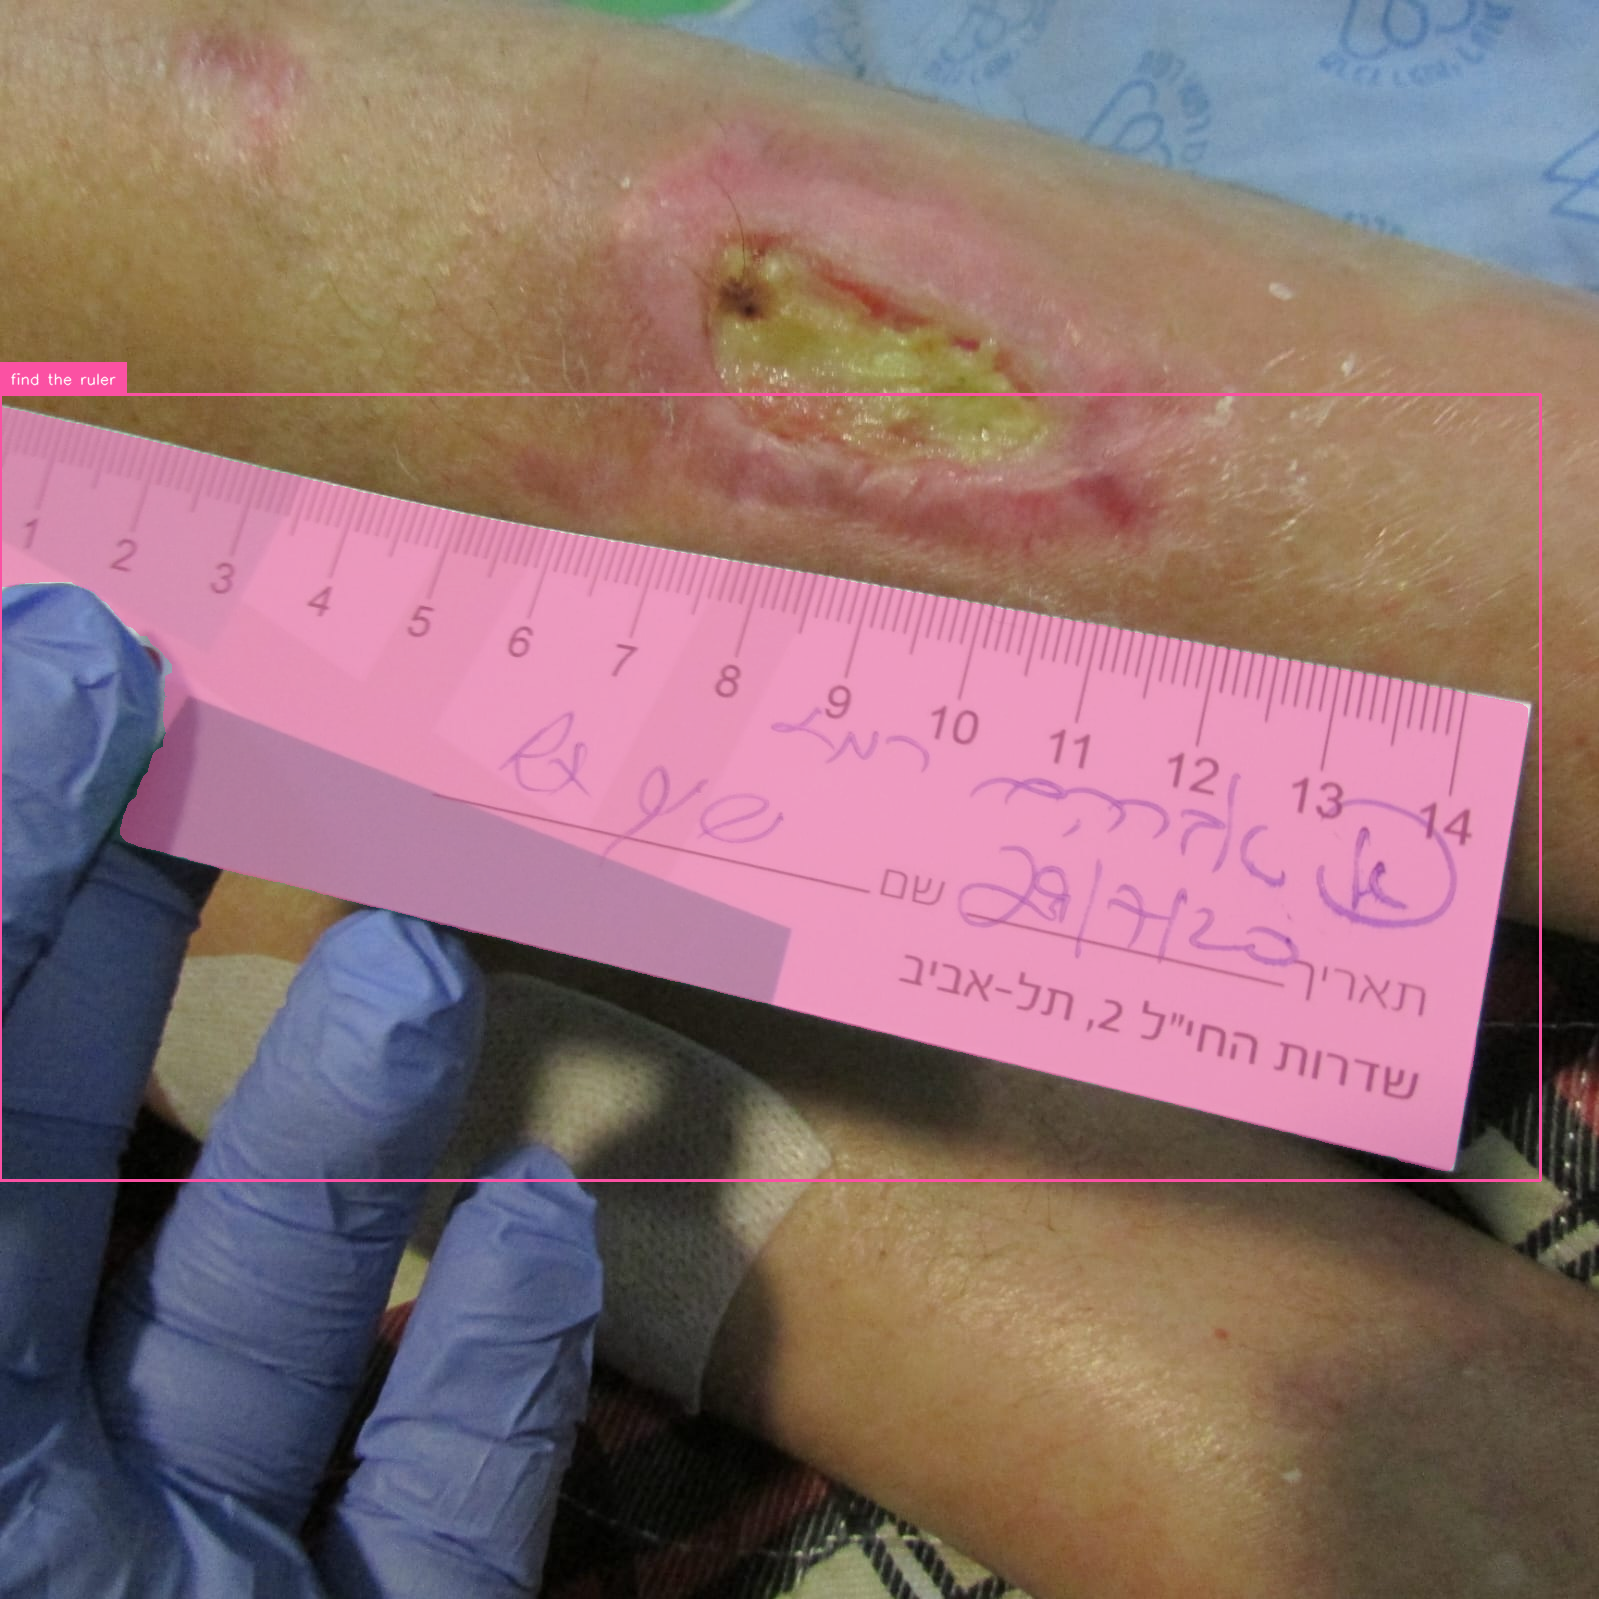

In [89]:
annotated